# 1. Ackley Function

In [10]:
import torch
import gpytorch
import botorch
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bmh")
from tqdm.notebook import tqdm

torch.set_default_dtype(torch.double)

# ----------------------------------------------------------------------
# Objective (negative Ackley-like) – we MAXIMIZE this
# ----------------------------------------------------------------------
def forrester_1d(x: torch.Tensor) -> torch.Tensor:
    y = -20 * torch.exp(-0.2 * torch.abs(x)) \
          - torch.exp(torch.cos(2 * math.pi * x)) + 20 + math.e    
    return -y.squeeze(-1)


# ----------------------------------------------------------------------
# Visualization
# ----------------------------------------------------------------------
def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    x_plot = xs
    x_plot_1d = x_plot.flatten()

    with torch.no_grad():
        pred = likelihood(model(x_plot))
        mean = pred.mean
        lower, upper = pred.confidence_region()

        if policy is not None:
            acquisition = policy(x_plot.unsqueeze(1)).flatten()

    if policy is None:
        plt.figure(figsize=(8, 3))
        plt.plot(x_plot_1d, ys, c="r", label="objective")
        plt.scatter(train_x, train_y, c="k", marker="x", label="observations")
        plt.plot(x_plot_1d, mean, label="GP mean")
        plt.fill_between(x_plot_1d, lower, upper, alpha=0.3)
        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                               gridspec_kw={"height_ratios": [2, 1]})

        # Posterior
        ax[0].plot(x_plot_1d, ys, c="r", label="objective")
        ax[0].scatter(train_x, train_y, c="k", marker="x", label="observations")
        ax[0].plot(x_plot_1d, mean, label="GP mean")
        ax[0].fill_between(x_plot_1d, lower, upper, alpha=0.3)
        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted")
        ax[0].legend()

        # Acquisition
        ax[1].plot(x_plot_1d, acquisition, c="g")
        ax[1].fill_between(x_plot_1d, acquisition, 0, alpha=0.4)
        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted")

        plt.show()


# ----------------------------------------------------------------------
# Composite Kernel GP Model: (RQ + RQ) * RBF
# ----------------------------------------------------------------------
class GPModelComposite(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()

        kernel = (gpytorch.kernels.RQKernel() + gpytorch.kernels.RQKernel()) * gpytorch.kernels.RBFKernel()

        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )


# ----------------------------------------------------------------------
# RBF Kernel GP Model
# ----------------------------------------------------------------------
class GPModelRBF(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )
    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )


# ----------------------------------------------------------------------
# Training function (works for both kernels)
# ----------------------------------------------------------------------
def fit_gp_model(model_class, train_x, train_y, num_iters=300):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = model_class(train_x, train_y, likelihood)
    likelihood.noise = 1e-4

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for _ in tqdm(range(num_iters)):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()
    return model, likelihood



🔁 Trial 1/5 — Composite Kernel


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 1/5 — RBF Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 2/5 — Composite Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 2/5 — RBF Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 3/5 — Composite Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 3/5 — RBF Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 4/5 — Composite Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 4/5 — RBF Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 5/5 — Composite Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 5/5 — RBF Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\optim\optimize.py:331: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


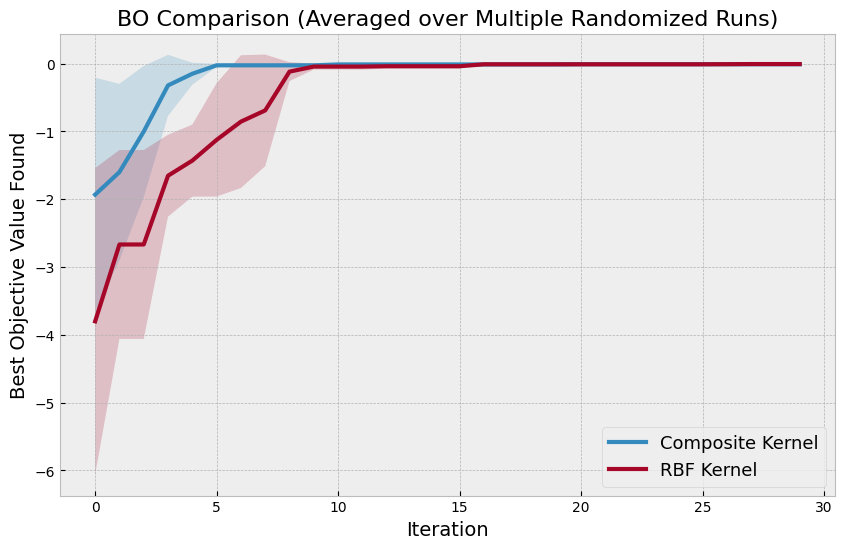

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

num_trials = 5          # how many independent runs
num_queries = 30         # BO iterations per run
bound = 5.0

# Storage for all trials
comp_all = []   # list of length num_trials, each entry is list of 20 incumbents
rbf_all  = []

for trial in range(num_trials):
    print(f"\n🔁 Trial {trial+1}/{num_trials} — Composite Kernel")

    # Random initial design
    train_x = (torch.rand(10,1) * 2 * bound - bound).double()
    train_y = forrester_1d(train_x)

    f_hist_comp = []

    for it in range(num_queries):
        # Record incumbent
        idx = train_y.argmax()
        f_hist_comp.append(train_y[idx].item())

        # Fit GP
        model, likelihood = fit_gp_model(GPModelComposite, train_x, train_y)

        # EI Acquisition
        EI = botorch.acquisition.analytic.ExpectedImprovement(
            model=model, best_f=train_y.max().item()
        )

        bounds = torch.tensor([[-bound], [bound]])
        next_x, _ = botorch.optim.optimize_acqf(
            EI, bounds=bounds, q=1, num_restarts=20, raw_samples=50
        )

        next_y = forrester_1d(next_x).flatten()

        # Update dataset
        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

    comp_all.append(f_hist_comp)


    # ---------------------------------------------------------------
    print(f"\n🔁 Trial {trial+1}/{num_trials} — RBF Kernel")

    # New random initial design
    train_x = (torch.rand(5,1) * 2 * bound - bound).double()
    train_y = forrester_1d(train_x)

    f_hist_rbf = []

    for it in range(num_queries):
        idx = train_y.argmax()
        f_hist_rbf.append(train_y[idx].item())

        model, likelihood = fit_gp_model(GPModelRBF, train_x, train_y)

        EI = botorch.acquisition.analytic.ExpectedImprovement(
            model=model, best_f=train_y.max().item()
        )

        next_x, _ = botorch.optim.optimize_acqf(
            EI, bounds=bounds, q=1, num_restarts=20, raw_samples=50
        )

        next_y = forrester_1d(next_x).flatten()
        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

    rbf_all.append(f_hist_rbf)


# ----------------------------------------------------------------------
# Compute mean and confidence intervals
# ----------------------------------------------------------------------
comp_array = np.array(comp_all)     # shape: (num_trials, num_queries)
rbf_array  = np.array(rbf_all)

mean_comp = comp_array.mean(axis=0)
std_comp  = comp_array.std(axis=0)

mean_rbf = rbf_array.mean(axis=0)
std_rbf  = rbf_array.std(axis=0)

iters = np.arange(num_queries)

# ----------------------------------------------------------------------
# Plot comparison with mean ± std shading
# ----------------------------------------------------------------------
plt.figure(figsize=(10,6))

plt.plot(iters, mean_comp, label="Composite Kernel", linewidth=3)
plt.fill_between(iters, mean_comp - std_comp, mean_comp + std_comp,
                 alpha=0.2)

plt.plot(iters, mean_rbf, label="RBF Kernel", linewidth=3)
plt.fill_between(iters, mean_rbf - std_rbf, mean_rbf + std_rbf,
                 alpha=0.2)

plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Best Objective Value Found", fontsize=14)
plt.title("BO Comparison (Averaged over Multiple Randomized Runs)", fontsize=16)
plt.legend(fontsize=13)
plt.grid(True)
plt.show()


# 2. Dropwave Function

In [2]:
# ----------------------------------------------------------------------
# Objective (negative Dropwave-like) – we MAXIMIZE this
# ----------------------------------------------------------------------
def forrester_1d(x: torch.Tensor) -> torch.Tensor:
    y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)
    return y.squeeze(-1)

In [4]:
# ----------------------------------------------------------------------
# Training function (works for both kernels)
# ----------------------------------------------------------------------
def fit_gp_model(model_class, train_x, train_y, num_iters=300):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = model_class(train_x, train_y, likelihood)
    likelihood.noise = 1e-4

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for _ in tqdm(range(num_iters)):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()
    return model, likelihood

In [8]:
# ----------------------------------------------------------------------
# Composite Kernel GP Model: RQ * (RQ + Periodic)
# ----------------------------------------------------------------------
class GPModelComposite(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()

        kernel = gpytorch.kernels.RQKernel() + (
            gpytorch.kernels.RQKernel() + gpytorch.kernels.RBFKernel()
        )

        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )


# ----------------------------------------------------------------------
# RBF Kernel GP Model
# ----------------------------------------------------------------------
class GPModelRBF(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )
    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )



🔁 Trial 1/5 — Composite Kernel


C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 1/5 — RBF Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 2/5 — Composite Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 2/5 — RBF Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 3/5 — Composite Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 3/5 — RBF Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 4/5 — Composite Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 4/5 — RBF Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 5/5 — Composite Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]


🔁 Trial 5/5 — RBF Kernel


C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\shafiq\.conda\envs\BO\Lib\site-packages\botorch\acquisition\analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
C:\Users\shafiq\AppData\Local\Temp\ipykernel_1208\2616702595.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (1 + np.cos(12*x)) / (0.5*x**2 + 2)


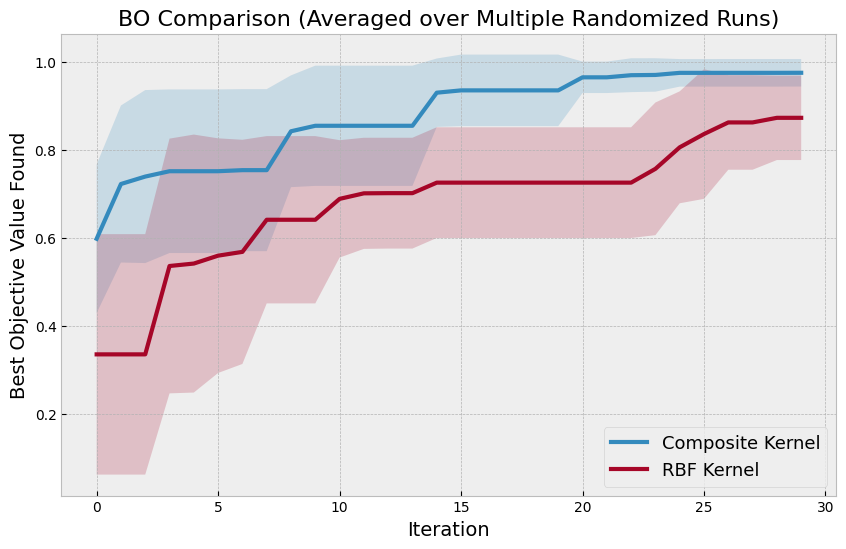

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

num_trials = 5          # how many independent runs
num_queries = 30         # BO iterations per run
bound = 5.0

# Storage for all trials
comp_all = []   # list of length num_trials, each entry is list of 20 incumbents
rbf_all  = []

for trial in range(num_trials):
    print(f"\n🔁 Trial {trial+1}/{num_trials} — Composite Kernel")

    # Random initial design
    train_x = (torch.rand(10,1) * 2 * bound - bound).double()
    train_y = forrester_1d(train_x)

    f_hist_comp = []

    for it in range(num_queries):
        # Record incumbent
        idx = train_y.argmax()
        f_hist_comp.append(train_y[idx].item())

        # Fit GP
        model, likelihood = fit_gp_model(GPModelComposite, train_x, train_y)

        # EI Acquisition
        EI = botorch.acquisition.analytic.ExpectedImprovement(
            model=model, best_f=train_y.max().item()
        )

        bounds = torch.tensor([[-bound], [bound]])
        next_x, _ = botorch.optim.optimize_acqf(
            EI, bounds=bounds, q=1, num_restarts=20, raw_samples=50
        )

        next_y = forrester_1d(next_x).flatten()

        # Update dataset
        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

    comp_all.append(f_hist_comp)


    # ---------------------------------------------------------------
    print(f"\n🔁 Trial {trial+1}/{num_trials} — RBF Kernel")

    # New random initial design
    train_x = (torch.rand(2,1) * 2 * bound - bound).double()
    train_y = forrester_1d(train_x)

    f_hist_rbf = []

    for it in range(num_queries):
        idx = train_y.argmax()
        f_hist_rbf.append(train_y[idx].item())

        model, likelihood = fit_gp_model(GPModelRBF, train_x, train_y)

        EI = botorch.acquisition.analytic.ExpectedImprovement(
            model=model, best_f=train_y.max().item()
        )

        next_x, _ = botorch.optim.optimize_acqf(
            EI, bounds=bounds, q=1, num_restarts=20, raw_samples=50
        )

        next_y = forrester_1d(next_x).flatten()
        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

    rbf_all.append(f_hist_rbf)


# ----------------------------------------------------------------------
# Compute mean and confidence intervals
# ----------------------------------------------------------------------
comp_array = np.array(comp_all)     # shape: (num_trials, num_queries)
rbf_array  = np.array(rbf_all)

mean_comp = comp_array.mean(axis=0)
std_comp  = comp_array.std(axis=0)

mean_rbf = rbf_array.mean(axis=0)
std_rbf  = rbf_array.std(axis=0)

iters = np.arange(num_queries)

# ----------------------------------------------------------------------
# Plot comparison with mean ± std shading
# ----------------------------------------------------------------------
plt.figure(figsize=(10,6))

plt.plot(iters, mean_comp, label="Composite Kernel", linewidth=3)
plt.fill_between(iters, mean_comp - std_comp, mean_comp + std_comp,
                 alpha=0.2)

plt.plot(iters, mean_rbf, label="RBF Kernel", linewidth=3)
plt.fill_between(iters, mean_rbf - std_rbf, mean_rbf + std_rbf,
                 alpha=0.2)

plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Best Objective Value Found", fontsize=14)
plt.title("BO Comparison (Averaged over Multiple Randomized Runs)", fontsize=16)
plt.legend(fontsize=13)
plt.grid(True)
plt.show()


# 3. Multiobjective Optimization with In-house Printability Data

Restart 1/5
Restart 2/5
Restart 3/5
Restart 4/5
Restart 5/5


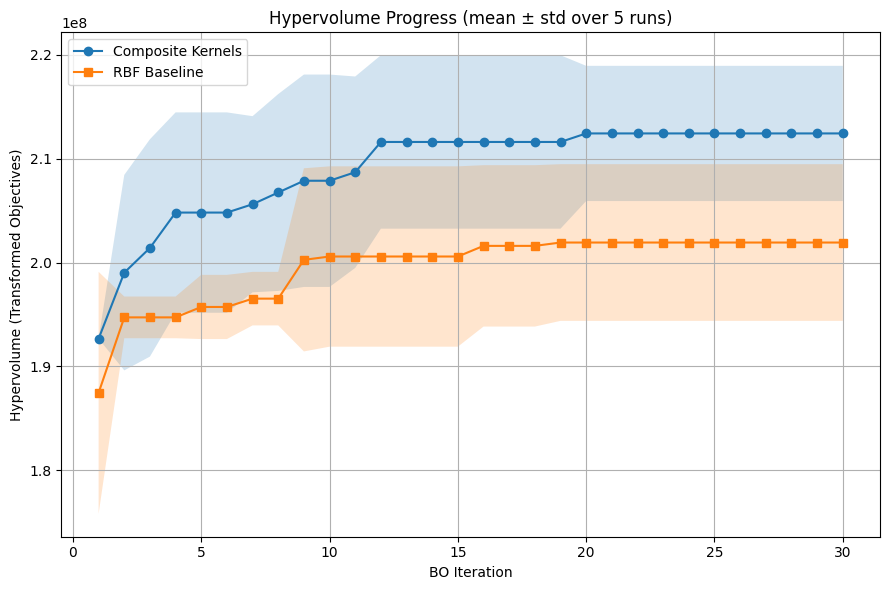

In [16]:
# ============================================================
# 1) Imports
# ============================================================

import math
import numpy as np
import torch

torch.set_default_dtype(torch.double)

import gpytorch
import pandas as pd

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.models.model_list_gp_regression import ModelListGP

from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

from botorch.optim import optimize_acqf

from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.utils.multi_objective.hypervolume import Hypervolume

from botorch.exceptions import ModelFittingError

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")


# ============================================================
# 2) SETTINGS
# ============================================================

num_input = 1
bounds = torch.stack([torch.zeros(num_input), torch.ones(num_input)])  # normalized [0, 1]

num_obj = 3   # LOF, Ball, Key (after transformation)

iterations = 30          # BO iterations per run
initial_samples = 10     # shared initial design size

batch_size = 1
num_restart = 20
raw_samples = 128

restarts = 5             # number of independent BO runs per model

torch.manual_seed(0)


# ============================================================
# 3) LOAD DATASET & DIRECT-LOOKUP OBJECTIVE
# ============================================================

DATA_CSV = "Printability_Data.csv"
df = pd.read_csv(DATA_CSV)

# Average duplicates
grouped = df.groupby("LED", as_index=False)[["LOF", "Ball", "Key"]].mean()

# Convert to torch
led_raw = torch.tensor(grouped["LED"].values, dtype=torch.double).unsqueeze(-1)
y_raw   = torch.tensor(grouped[["LOF", "Ball", "Key"]].values, dtype=torch.double)

# Normalize LED
led_min, led_max = led_raw.min(), led_raw.max()
led_norm = (led_raw - led_min) / (led_max - led_min)

candidate_X = led_norm

# ============================================================
# TRANSFORM: convert to MAXIMIZATION objectives
# LOF ↓ → -LOF
# Ball ↓ → -Ball
# Key ↑ → +Key
# ============================================================

candidate_Y = torch.column_stack([
    -y_raw[:, 0],   # minimize LOF
    -y_raw[:, 1],   # minimize Ball
    y_raw[:, 2],    # maximize Key
])

# Reference point for hypervolume (in transformed space)
ref_point = candidate_Y.min(dim=0).values - 0.1


# ============================================================
# Lookup objective from dataset (nearest LED)
# ============================================================

def lookup_objective(x: torch.Tensor) -> torch.Tensor:
    """Return transformed objectives for nearest LED in dataset."""
    if x.dim() == 1:
        x = x.unsqueeze(-1)

    x = x.clamp(0.0, 1.0)

    # Compute distances to stored LED values
    dists = torch.cdist(x, candidate_X)
    idx = dists.argmin(dim=1)

    return candidate_Y[idx]


# ============================================================
# 4) MODEL BUILDERS
# ============================================================

def _fit_model_safely(mll: ExactMarginalLogLikelihood):
    try:
        fit_gpytorch_mll(mll)
    except ModelFittingError:
        print("Warning: GP failed to fit; using initial hyperparameters.")
    return mll.model


def build_model_composite(train_x, train_y):
    """
    Composite model for 3 objectives:
      Obj1 (LOF):  (RQ + RQ)*RQ
      Obj2 (Ball): RQ
      Obj3 (Key):  RBF
    """
    models = []

    # Obj 1
    kernel1 = (gpytorch.kernels.RQKernel() +
               gpytorch.kernels.RQKernel()) * gpytorch.kernels.RQKernel()
    m1 = SingleTaskGP(
        train_x, train_y[:, 0:1],
        covar_module=gpytorch.kernels.ScaleKernel(kernel1),
        input_transform=Normalize(d=num_input),
        outcome_transform=Standardize(m=1)
    )
    mll1 = ExactMarginalLogLikelihood(m1.likelihood, m1)
    models.append(_fit_model_safely(mll1))

    # Obj 2
    kernel2 = gpytorch.kernels.RQKernel()
    m2 = SingleTaskGP(
        train_x, train_y[:, 1:2],
        covar_module=gpytorch.kernels.ScaleKernel(kernel2),
        input_transform=Normalize(d=num_input),
        outcome_transform=Standardize(m=1)
    )
    mll2 = ExactMarginalLogLikelihood(m2.likelihood, m2)
    models.append(_fit_model_safely(mll2))

    # Obj 3
    kernel3 = gpytorch.kernels.RBFKernel()
    m3 = SingleTaskGP(
        train_x, train_y[:, 2:3],
        covar_module=gpytorch.kernels.ScaleKernel(kernel3),
        input_transform=Normalize(d=num_input),
        outcome_transform=Standardize(m=1)
    )
    mll3 = ExactMarginalLogLikelihood(m3.likelihood, m3)
    models.append(_fit_model_safely(mll3))

    return ModelListGP(*models)


def build_model_rbf(train_x, train_y):
    """Simple RBF baseline GP for all objectives."""
    models = []
    for i in range(num_obj):
        base_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        m = SingleTaskGP(
            train_x, train_y[:, i:i+1],
            covar_module=base_kernel,
            input_transform=Normalize(d=num_input),
            outcome_transform=Standardize(m=1),
        )
        mll = ExactMarginalLogLikelihood(m.likelihood, m)
        models.append(_fit_model_safely(mll))
    return ModelListGP(*models)


# ============================================================
# 5) ACQUISITION (qEHVI)
# ============================================================

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))

def get_acquisition(model, train_y):
    pareto_y = train_y[is_non_dominated(train_y)]
    part = FastNondominatedPartitioning(ref_point=ref_point, Y=pareto_y)

    return qExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.tolist(),
        partitioning=part,
        sampler=sampler,
    )


def get_candidate(acq):
    cand, _ = optimize_acqf(
        acq,
        q=1,
        bounds=bounds,
        num_restarts=num_restart,
        raw_samples=raw_samples,
    )
    return cand


# ============================================================
# 6) ONE BO RUN
# ============================================================

def run_one_BO(model_builder, init_x, init_y):
    train_x = init_x.clone()
    train_y = init_y.clone()

    hv_list = []
    hv_calc = Hypervolume(ref_point)

    for _ in range(iterations):
        model = model_builder(train_x, train_y)
        acq = get_acquisition(model, train_y)

        x_new = get_candidate(acq)
        y_new = lookup_objective(x_new)

        train_x = torch.cat([train_x, x_new], dim=0)
        train_y = torch.cat([train_y, y_new], dim=0)

        pareto = train_y[is_non_dominated(train_y)]
        hv_list.append(hv_calc.compute(pareto))

    return torch.tensor(hv_list)


# ============================================================
# 7) MULTIPLE RESTARTS
# ============================================================

all_hv_composite = torch.zeros(restarts, iterations)
all_hv_rbf       = torch.zeros(restarts, iterations)

for r in range(restarts):
    print(f"Restart {r+1}/{restarts}")

    torch.manual_seed(r)
    init_x = torch.rand(initial_samples, num_input)
    init_y = lookup_objective(init_x)

    torch.manual_seed(1000 + r)
    all_hv_composite[r] = run_one_BO(build_model_composite, init_x, init_y)

    torch.manual_seed(1000 + r)
    all_hv_rbf[r] = run_one_BO(build_model_rbf, init_x, init_y)

mean_hv_composite = all_hv_composite.mean(dim=0)
std_hv_composite  = all_hv_composite.std(dim=0)

mean_hv_rbf = all_hv_rbf.mean(dim=0)
std_hv_rbf  = all_hv_rbf.std(dim=0)


# ============================================================
# 8) PLOT RESULTS
# ============================================================

iters_axis = np.arange(1, iterations + 1)

plt.figure(figsize=(9, 6))

plt.plot(iters_axis, mean_hv_composite.numpy(), label="Composite Kernels", marker='o')
plt.fill_between(
    iters_axis,
    (mean_hv_composite - std_hv_composite).numpy(),
    (mean_hv_composite + std_hv_composite).numpy(),
    alpha=0.2,
)

plt.plot(iters_axis, mean_hv_rbf.numpy(), label="RBF Baseline", marker='s')
plt.fill_between(
    iters_axis,
    (mean_hv_rbf - std_hv_rbf).numpy(),
    (mean_hv_rbf + std_hv_rbf).numpy(),
    alpha=0.2,
)

plt.xlabel("BO Iteration")
plt.ylabel("Hypervolume (Transformed Objectives)")
plt.title(f"Hypervolume Progress (mean ± std over {restarts} runs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


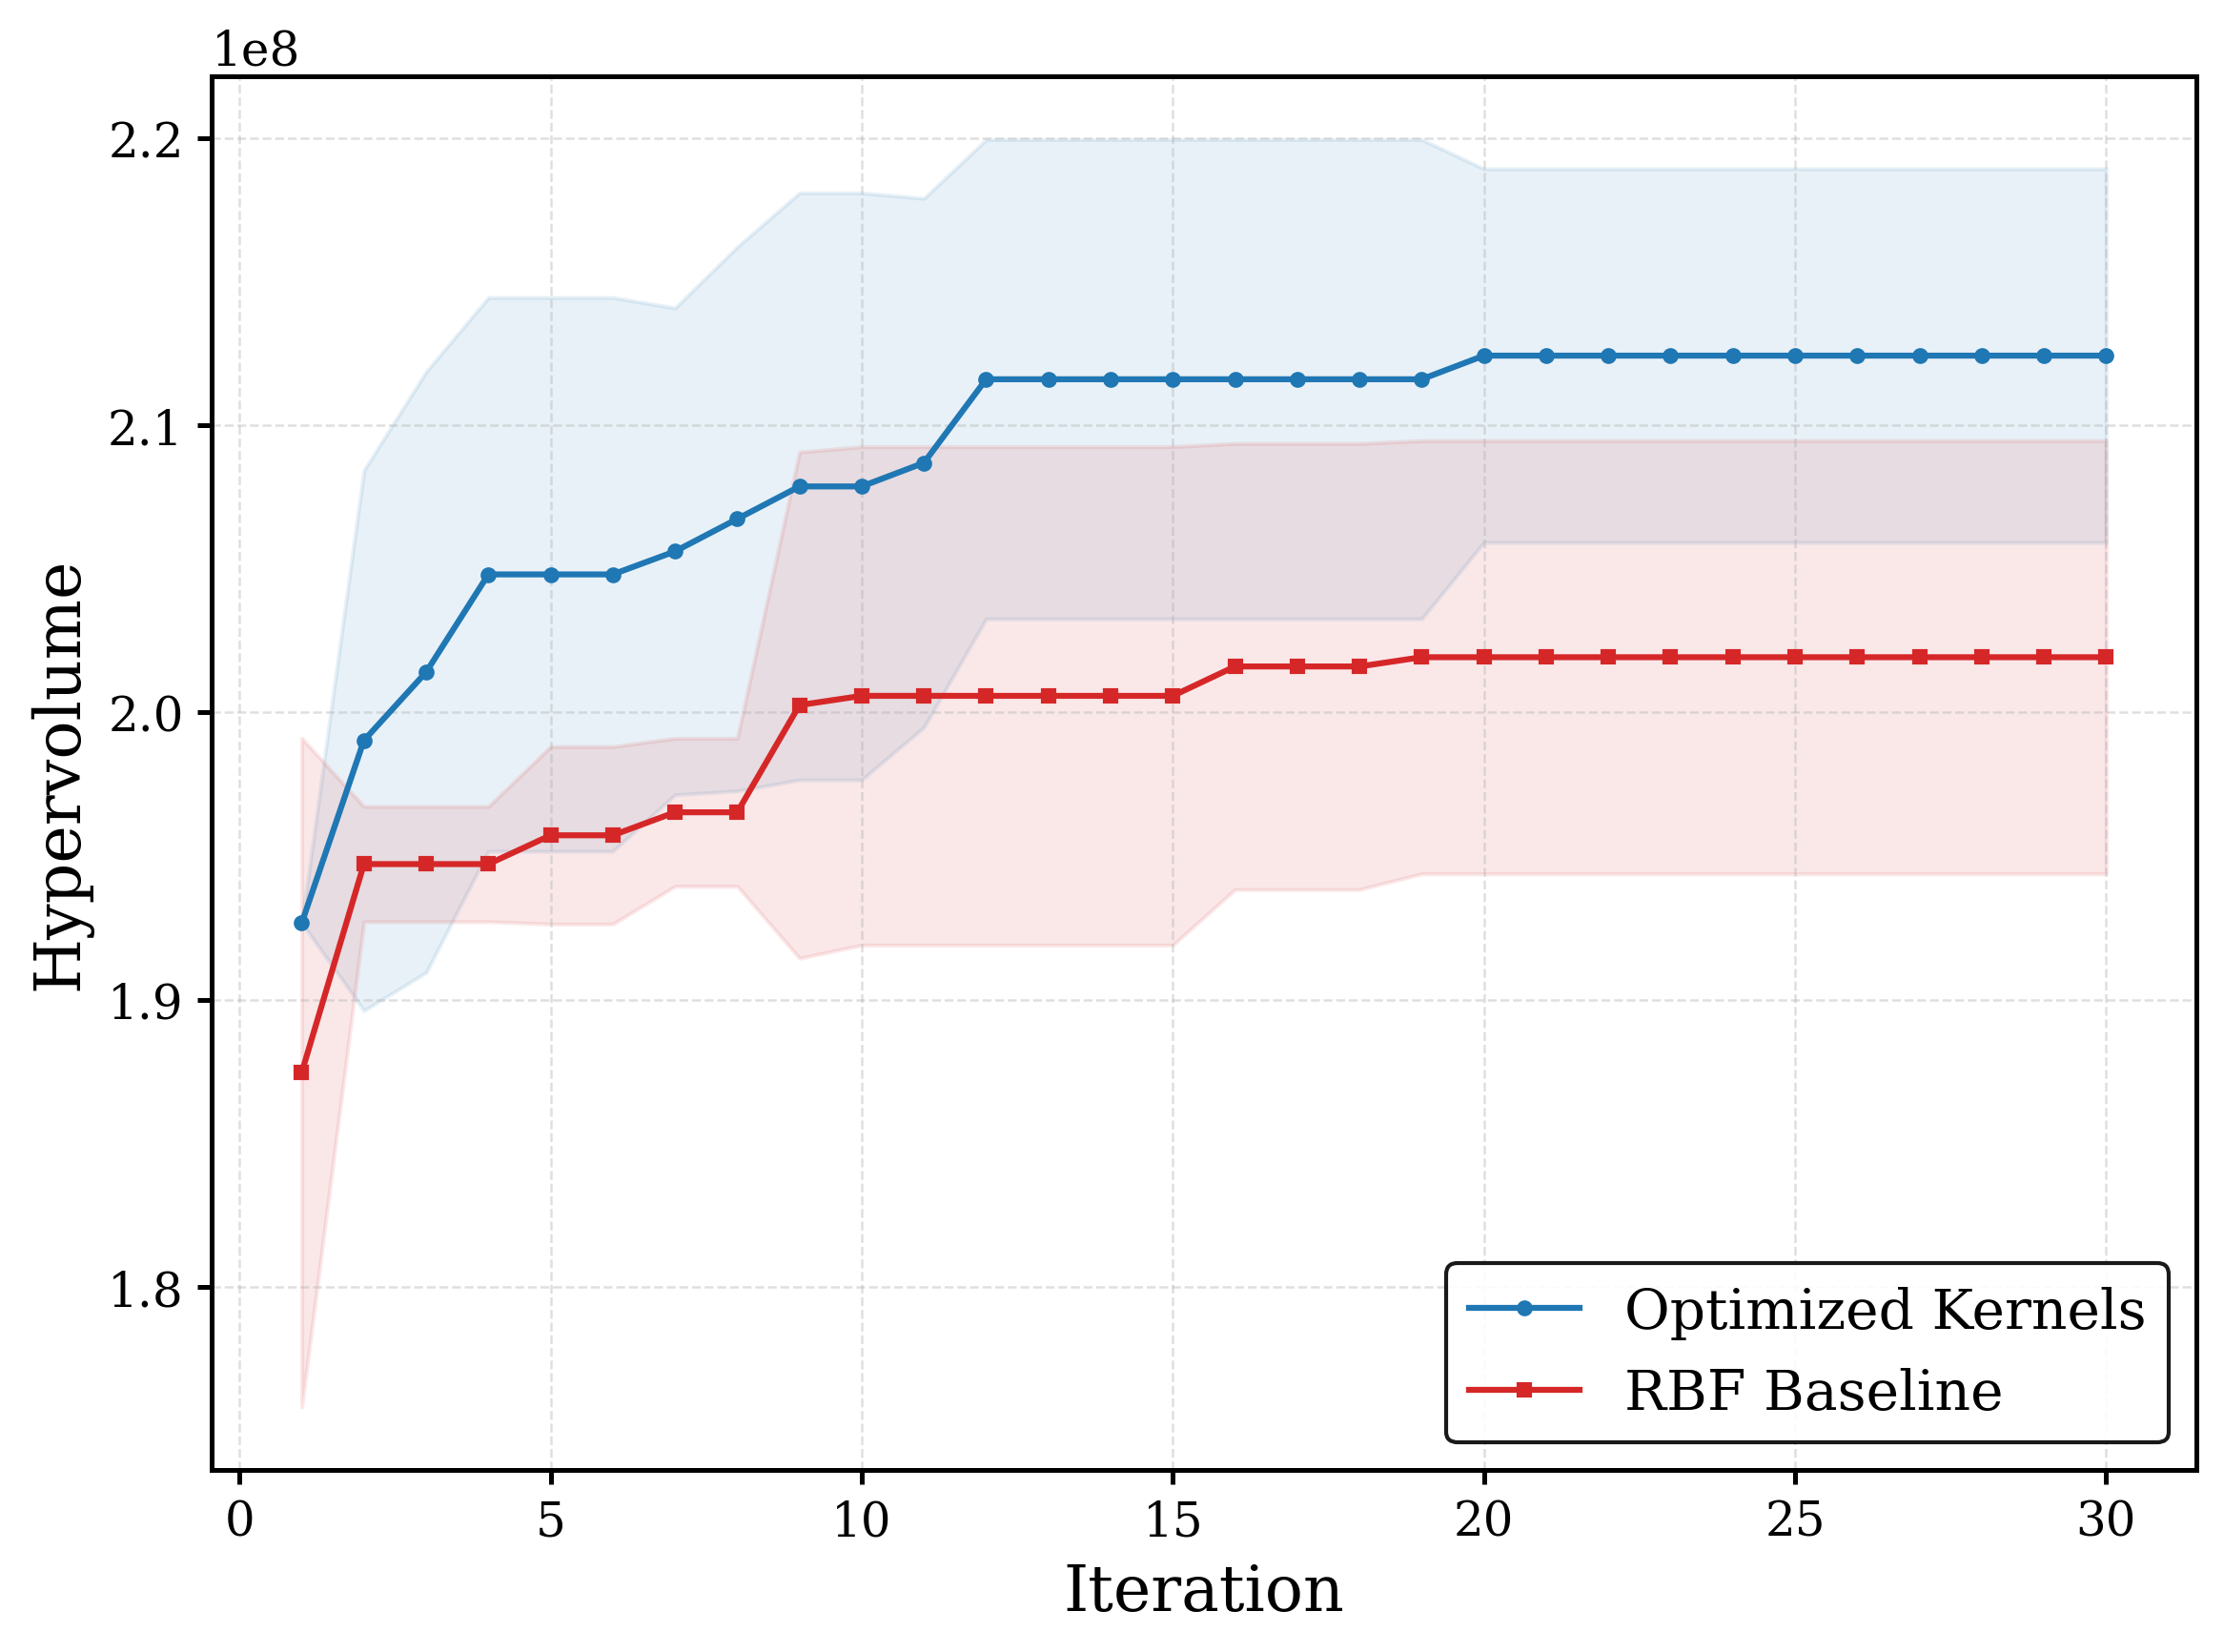

In [22]:


iters_axis = np.arange(1, iterations + 1)

plt.figure(figsize=(8, 6), dpi=300)

plt.rcParams.update({
    "font.size": 14,
    "font.family": "serif",
    "axes.linewidth": 1.2,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
})

# --- Optimized Kernels ---
plt.plot(
    iters_axis,
    mean_hv_composite.numpy(),
    label="Optimized Kernels",
    color="#1f77b4",
    linewidth=1.5,
    marker="o",
    markersize=3,
)
plt.fill_between(
    iters_axis,
    (mean_hv_composite - std_hv_composite).numpy(),
    (mean_hv_composite + std_hv_composite).numpy(),
    color="#1f77b4",
    alpha=0.1,
)

# --- RBF Baseline ---
plt.plot(
    iters_axis,
    mean_hv_rbf.numpy(),
    label="RBF Baseline",
    color="#d62728",
    linewidth=1.5,
    marker="s",
    markersize=3,
)
plt.fill_between(
    iters_axis,
    (mean_hv_rbf - std_hv_rbf).numpy(),
    (mean_hv_rbf + std_hv_rbf).numpy(),
    color="#d62728",
    alpha=0.1,
)

# --- Labels ---
plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Hypervolume", fontsize=16)

# --- Grid ---
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.4)

# --- Legend ---
plt.legend(
    fontsize=14,
    frameon=True,
    edgecolor="black",
    framealpha=0.9,
)

plt.tight_layout()
plt.show()
